In [49]:
from glob import glob
import pandas as pd
from Bio import SeqIO
from paretoset import paretoset
import numpy as np
import datetime
import re

ADD GETORF INFO

In [2]:
files_dict = {filename.split('/')[-1].split('.')[0]: filename for filename in glob('results/orf_x_ref/*.csv')}
dfs = {key: pd.read_csv(file_path) for key, file_path in files_dict.items()}
getorf = '/home/tobamo/analize/project-tobamo/analysis/whole_orf/results/getorf_output_find1_min_360_max_3510.fasta'

In [3]:
with open(getorf, "r") as file:
    data = [record.description for record in SeqIO.parse(file, "fasta")]

getorf = pd.DataFrame({
    'orf_name': [item.split()[0].replace('=', '_') for item in data],
    'orf_start': [int(item.split('[')[1].split(' - ')[0]) for item in data],
    'orf_end': [int(item.split(' - ')[1].split(']')[0]) for item in data],
    'orientation': ['REVERSE' if "(REVERSE SENSE)" in item else 'FORWARD' for item in data]
})

In [4]:
for key, df in dfs.items():
    merged = df.merge(getorf, how='left', on='orf_name')
    # merged.to_csv(f'results/orf_x_ref_getorf_info/{key}_getorf_info.csv', index=False)
    dfs[key] = merged

FILTER AND MERGE

In [5]:
# define pareto function for cp and mp (abs_diff - min)
def calculate_pareto_set(group):
    group['on_pareto_front'] = paretoset(group[['identity_score', 'N/aln_len', 'gap_ratio']], sense=["max", "max", "min"])
    return group

In [6]:
for key, df in dfs.items():
    pareto = df.groupby('contig_name', group_keys=False).apply(calculate_pareto_set)
    dfs[key] = pareto

FIGURE OUT LIMITS FROM REFERENCE FILES

In [7]:
f_dict = {filename.split('/')[-1].split('.')[0]: filename for filename in glob('results/reference_limits/*.csv')}
ref_dfs = {key: pd.read_csv(file_path) for key, file_path in f_dict.items()}

In [8]:
final_tables = {}
metrics = {'identity_score': 'Identity Score', 'gap_ratio': 'Gap Ratio', 'N/aln_len': 'N/aln_len'}

# Iterate through each metric
for metric, label in metrics.items():
    max_scores_list = []
    min_scores_list = []
    
    # Iterate through each DataFrame
    for key, df in ref_dfs.items():
        max_scores_list.append(df.groupby('pair_type')[metric].max())
        min_scores_list.append(df.groupby('pair_type')[metric].min())

    max_scores_df = pd.concat(max_scores_list, axis=1, keys=ref_dfs.keys())
    min_scores_df = pd.concat(min_scores_list, axis=1, keys=ref_dfs.keys())

    final_tables[label] = pd.concat({
        f'Max {label}': max_scores_df.transpose(),
        f'Min {label}': min_scores_df.transpose()
    }, axis=1)

# Combine all final tables into a single table
final_table_combined = pd.concat(final_tables, axis=1)
final_table_combined

Identity Score                                   \
                 Max Identity Score               Min Identity Score   
pair_type                 og-tobamo tobamo-tobamo          og-tobamo   
rdrp_orf2_pareto           0.420635      1.000000           0.317734   
rdrp_orf1_pareto           0.353877      0.999105           0.283412   
cp_pareto                  0.407767      1.000000           0.184049   
mp_pareto                  0.321267      0.996212           0.202532   

                                   Gap Ratio                              \
                               Max Gap Ratio               Min Gap Ratio   
pair_type        tobamo-tobamo     og-tobamo tobamo-tobamo     og-tobamo   
rdrp_orf2_pareto      0.514019      0.035865      0.018367      0.003205   
rdrp_orf1_pareto      0.385379      0.050708      0.025907      0.028613   
cp_pareto             0.333333      0.079602      0.032680      0.021277   
mp_pareto             0.250951      0.061856      0.057047      0.028070   

                                   N/aln_len                              \
                               Max N/aln_len               Min N/aln_len   
pair_type        tobamo-tobamo     og-tobamo tobamo-tobamo     og-tobamo   
rdrp_orf2_pareto           0.0      0.996795           1.0      0.766600   
rdrp_orf1_pareto           0.0      0.839300           1.0      0.644068   
cp_pareto                  0.0      0.867021           1.0      0.453744   
mp_pareto                  0.0      0.899614           1.0      0.661932   

                                
                                
pair_type        tobamo-tobamo  
rdrp_orf2_pareto      0.841897  
rdrp_orf1_pareto      0.670753  
cp_pareto             0.746544  
mp_pareto             0.684366

In [9]:
# final_table_combined.to_excel('reference_limits_table.xlsx')

FILTER DFS

In [68]:
filtered_dfs = {}

for key, df in dfs.items():
    name = key.replace('orf_x_ref', 'pareto')

    id_score_lim_sl = final_table_combined.loc[(f'{name}'), ('Identity Score', 'Min Identity Score', 'tobamo-tobamo')]
    naln_len_lim_sl = final_table_combined.loc[(f'{name}'), ('N/aln_len', 'Min N/aln_len', 'tobamo-tobamo')]
    gap_ratio_lim_sl = final_table_combined.loc[(f'{name}'), ('Gap Ratio', 'Max Gap Ratio', 'tobamo-tobamo')]


    id_score_lim_ss = final_table_combined.loc[(f'{name}'), ('Identity Score', 'Max Identity Score', 'og-tobamo')]
    naln_len_lim_ss = final_table_combined.loc[(f'{name}'), ('N/aln_len', 'Max N/aln_len', 'og-tobamo')]
    gap_ratio_lim_ss = final_table_combined.loc[(f'{name}'), ('Gap Ratio', 'Min Gap Ratio', 'og-tobamo')]

    def filter_rows(dataframe):
        filtered_df = dataframe[(dataframe['identity_score'] >= id_score_lim_sl) & (dataframe['N/aln_len'] >= naln_len_lim_sl) & (dataframe['gap_ratio'] <= gap_ratio_lim_sl)]
        filtered_df['tax_trust'] = (
            (filtered_df['identity_score'] >= id_score_lim_ss) &
            (filtered_df['N/aln_len'] >= naln_len_lim_ss) &
            (filtered_df['gap_ratio'] <= gap_ratio_lim_ss)
        )
        return filtered_df

    filtered_df = filter_rows(df)
    filtered_dfs[key] = filtered_df

edit col names, add prefixes

In [69]:
num = 0

for key, df in filtered_dfs.items():
    name = key.replace('_orf_x_ref', '')
    df = df.drop(labels='SRR', axis=1)
    rnm = df[df['on_pareto_front'] == True].copy()
    rnm[f'idscore>{num}'] = np.where(rnm['identity_score'] > num, True, False)
    rnm.rename(columns={col: f'{name}_{col}' for col in rnm.columns if col not in ['contig_name']}, inplace=True)
    filtered_dfs[key] = rnm

In [70]:
# merge dataframes
megamerge = filtered_dfs['rdrp_orf1_orf_x_ref'].merge(filtered_dfs['rdrp_orf2_orf_x_ref'], on='contig_name', how='outer').merge(filtered_dfs['mp_orf_x_ref'], on='contig_name', how='outer').merge(filtered_dfs['cp_orf_x_ref'], on='contig_name', how='outer')

In [71]:
megamerge['SRR'] = megamerge["contig_name"].str.extract(r"_([A-Za-z0-9]+)$")

In [90]:
pd.options.mode.chained_assignment = None

megamerge['contig_len'] = megamerge['contig_name'].apply(lambda x: int(re.search(r'length_(\d+)|len_(\d+)', x).group(1) or re.search(r'len_(\d+)', x).group(1)))
megamerge['orientation_match'] = megamerge[['rdrp_orf1_orientation', 'rdrp_orf2_orientation', 'mp_orientation', 'cp_orientation']].apply(lambda row: len(set(row.dropna())) == 1, axis=1)
megamerge['different_orfs'] = megamerge[['rdrp_orf1_orf_name', 'rdrp_orf2_orf_name', 'mp_orf_name', 'cp_orf_name']].apply(
    lambda row: 'check' if len(set(row.dropna())) == 1 else 'different orfs',
    axis=1
)

In [91]:
# set first cols
first_columns = ['SRR', 'contig_name','different_orfs', 'contig_len',  f'rdrp_orf1_idscore>{num}',  f'rdrp_orf2_idscore>{num}', f'mp_idscore>{num}', f'cp_idscore>{num}']

# Reorder the columns
mega = megamerge[first_columns + [col for col in megamerge.columns if col not in first_columns]]

In [92]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
mega.to_csv(f'results/orf_x_ref_megamerge_{current_date}_filtered.csv')

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
df = mega[['contig_name', 'rdrp_orf1_idscore>0.5', 'rdrp_orf2_idscore>0.5', 'mp_idscore>0.5', 'cp_idscore>0.5']]

In [89]:
df.drop_duplicates()

,contig_name,rdrp_orf1_idscore>0.5,rdrp_orf2_idscore>0.5,mp_idscore>0.5,cp_idscore>0.5
0,NODE_123_length_4070_cov_4.588543_SRR11613515,True,NaN,False,NaN
27,NODE_1981_length_3457_cov_1.405325_SRR1777513,True,NaN,NaN,NaN
28,NODE_769_length_4549_cov_5.440295_SRR1781945,False,True,False,NaN
44,NODE_1666_length_3389_cov_1.992150_SRR1781945,False,NaN,NaN,NaN
52,k141_12641_flag_0_multi_415.0347_len_4142_SRR6...,True,NaN,NaN,NaN
...,...,...,...,...,...
2485,k141_34437_flag_1_multi_4.0000_len_688_SRR7288019,NaN,NaN,NaN,True
2486,NODE_10799_length_1062_cov_1.026396_SRR8554352,NaN,NaN,NaN,True
2487,NODE_19142_length_744_cov_2.724138_SRR8554352,NaN,NaN,NaN,True
2488,NODE_19470_length_736_cov_31.872534_SRR8554352,NaN,NaN,NaN,True


In [90]:
filtered = df.drop_duplicates().drop(columns=['contig_name'])

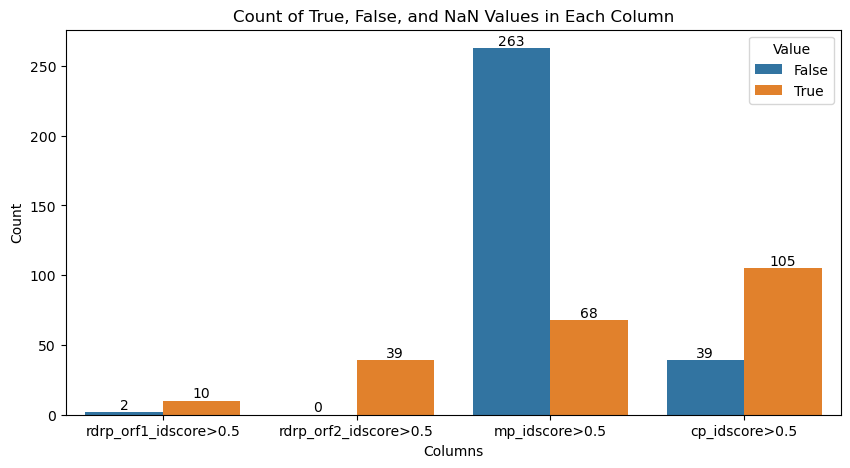

In [91]:
# Stacking the DataFrame
stacked_df = filtered.stack().reset_index()
stacked_df.columns = ['index', 'column', 'value']

# Specifying the order of x-axis labels
order = ['rdrp_orf1_idscore>0.5', 'rdrp_orf2_idscore>0.5', 'mp_idscore>0.5', 'cp_idscore>0.5']

# Plotting the count of each value in each column with sorted x-axis labels
plt.figure(figsize=(10,5))
ax = sns.countplot(data=stacked_df, x='column', hue='value', order=order)

# Adding counts above bars
for p in ax.patches:
    height = p.get_height()  # Get the height of the bar
    ax.annotate(f'{int(height)}',  # Annotation text
                (p.get_x() + p.get_width() / 2., height),  # Position
                ha='center', va='center',  # Horizontal and vertical alignment
                fontsize=10,  # Font size
                color='black',  # Color of the text
                xytext=(0, 5),  # Offset the text vertically by 5 units
                textcoords='offset points')  # Text coordinates relative to the point


plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Count of True, False, and NaN Values in Each Column')
plt.legend(title='Value', loc='upper right')
plt.show()